# Система автоматизированного выбора и настройки алгоритма классификации задачи кредитного скоринга

## Загрузка и анализ данных

### Загрузка библиотек, датасета для кредитного скоринга

Библиотеки:
* pandas
* sklearn
* kagglehub
* matplotlib
* seaborn
* tpot
* h20

In [180]:
import warnings
warnings.filterwarnings("ignore")

In [181]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import utils
from sklearn.metrics import(
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import MinMaxScaler

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
#matplotlib inline

In [182]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kornilovag94/bank-credit-default-loan-default")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\AntMur00\.cache\kagglehub\datasets\kornilovag94\bank-credit-default-loan-default\versions\2


In [183]:
data = pd.read_parquet(path+'/data/train_data/train_data_0.pq')

In [184]:
dataset_count=len(data)
print(f"Количество записей в первом файле датасета: {dataset_count}")

Количество записей в первом файле датасета: 1974724


In [185]:
import os
i = 1
while os.path.isfile(path+f'/data/train_data/train_data_{i}.pq'):
    temp_path = path+f'/data/train_data/train_data_{i}.pq'
    data_temp = len(pd.read_parquet(temp_path))
    dataset_count += data_temp
    i+=1
print(f"Общее количество записей в датасете: {dataset_count}")

Общее количество записей в датасете: 26162717


In [186]:
pd.set_option('display.max_columns', None)
data.head(30)

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0    0   1                18                    9          2          3   
1    0   2                18                    9         14         14   
2    0   3                18                    9          4          8   
3    0   4                 4                    1          9         12   
4    0   5                 5                   12         15          2   
5    0   6                 5                    0         11          8   
6    0   7                 3                    9          1          2   
7    0   8                 2                    9          2          3   
8    0   9                 1                    9         11         13   
9    0  10                 7                    9          2         10   
10   1   1                 8                    7         12         15   
11   1   2                 8                    7         13          2   
12   1   3                15                    7          7          6   
13   1   4                15                    3          7          6   
14   1   5                14                    4          7          6   
15   1   6                14                   14          1          0   
16   1   7                14                    3          8         11   
17   1   8                10                   14          2         14   
18   1   9                10                   14         15          9   
19   1  10                13                    6          0          1   
20   1  11                18                    8          1         16   
21   1  12                 2                    5         15          9   
22   1  13                 7                    9          4          8   
23   1  14                12                    6          1          8   
24   2   1                 0                    9          4          8   
25   2   2                13                   14         13          2   
26   2   3                12                    9          4          8   
27   3   1                13                   14          9          0   
28   3   2                13                    9         16          2   
29   3   3                 6                    0         14          7   

    pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0                16               10                      11   
1                12               12                       0   
2                 1               11                      11   
3                16                7                      12   
4                11               12                      10   
5                12               11                       4   
6                12               14                      15   
7                12               14                      15   
8                14                8                       2   
9                 8                8                      16   
10                9                1                       1   
11                9                1                       6   
12                9                1                       6   
13                9                1                       6   
14                9                1                       3   
15               13               13                       0   
16                6               13                       6   
17               13                5                      14   
18               13                3                      10   
19               14                8                      16   
20               15               14                      15   
21                7               15                      19   
22                1               11                       1   
23               14               11                      11   
24                1               11                       1   
25            

In [187]:
pd.reset_option('display.max_columns')

### Признаки


* id - идентификатор заявки;
* rn - порядковый номер кредитного продукта в кредитной истории;
* pre_since_opened - дни с даты открытия кредита до даты сбора данных;
* pre_since_confirmed - дни с даты подтверждения кредитной информации до даты сбора данных;
* pre_pterm - планируемое количество дней с даты открытия кредита до даты закрытия;
* pre_fterm - фактическое количество дней. с даты открытия кредита до даты закрытия;
* pre_till_pclose - планируемое количество дней с даты сбора данных до даты закрытия кредита;
* pre_till_fclose - фактическое количество дней с даты сбора данных до даты закрытия кредита;
* pre_loans_credit_limit - кредитный лимит;
* pre_loans_next_pay_summ - сумма следующего платежа по кредиту;
* pre_loans_outstanding - сумма непогашенного кредита;
* pre_loans_total_overdue - текущая сумма просрочки;
* pre_loans_max_overdue_sum - максимальная сумма просрочки;
* pre_loans_credit_cost_rate - общая стоимость кредита;
* pre_loans5 - количество просрочка до 5 дней;
* pre_loans530 - номер количество просрочек от 5 до 30 дней;
* pre_loans3060 - количество просрочек от 30 до 60 дней;
* pre_loans6090 - количество просрочек от 60 до 90 дней;
* pre_loans90 - количество просрочек более 90 дней;
* is_zero_loans_5 - флаг: нет просрочек до 5 дней;
* is_zero_loans_530 - флаг: нет просрочек от 5 до 30 дней;
* is_zero_loans_3060 - флаг: нет просрочек от 30 до 60 дней;
* is_zero_loans_6090 - флаг: нет правонарушения в области от 60 до 90 дней;
* is_zero_loans90 - флаг: просрочки не превышают 90 дней;
* pre_util - отношение суммы непогашенного кредита к кредитному лимиту;
* pre_over2limit - отношение текущей просроченной задолженности к кредитному лимиту;
* pre_maxover2limit - отношение максимальной просроченной задолженности к кредитному лимиту;
* is_zero_util - флаг: отношение суммы непогашенного кредита к кредитному лимиту равно 0;
* is_zero_over2limit - флаг: отношение текущей просроченной задолженности к кредитному лимиту равно 0;
* is_zero_maxover2limit - флаг: отношение максимальной просроченной задолженности к кредитному лимиту равно 0;
* enc_paym_{0...n} - ежемесячно статусы платежей за последние n месяцев;
* enc_loans_account_holder_type - тип отношения к кредиту;
* enc_loans_credit_status - статус кредита;
* enc_loans_account_cur - валюта кредита;
* enc_loans_credit_type - тип кредита; 
* pclose_flag - флаг: планируемое количество дней с даты открытия до даты закрытия кредита;
* fclose_flag - флаг: фактическое количество дней с даты открытия кредита до даты закрытия не определено.

In [188]:
data.shape

(1974724, 61)

## Предобработка данных

In [189]:
print(f'enc_loans_account_holder_type unique {np.unique(data.enc_loans_account_holder_type)}')
print(f'enc_loans_credit_status {np.unique(data.enc_loans_credit_status)}')
print(f'enc_loans_account_cur unique {np.unique(data.enc_loans_account_cur)}')
print(f'enc_loans_credit_type unique {np.unique(data.enc_loans_credit_type)}')

enc_loans_account_holder_type unique [0 1 2 3 4 5 6]
enc_loans_credit_status [0 1 2 3 4 5 6]
enc_loans_account_cur unique [0 1 2 3]
enc_loans_credit_type unique [0 1 2 3 4 5]


In [190]:
for i in range(25):
    print(f'enc_paym_{i} unique {np.unique(data[f"enc_paym_{i}"])}')

enc_paym_0 unique [0 1 2 3]
enc_paym_1 unique [0 1 2 3]
enc_paym_2 unique [0 1 2 3]
enc_paym_3 unique [0 1 2 3]
enc_paym_4 unique [0 1 2 3]
enc_paym_5 unique [0 1 2 3]
enc_paym_6 unique [0 1 2 3]
enc_paym_7 unique [0 1 2 3]
enc_paym_8 unique [0 1 2 3]
enc_paym_9 unique [0 1 2 3]
enc_paym_10 unique [0 1 2 3]
enc_paym_11 unique [1 2 3 4]
enc_paym_12 unique [0 1 2 3]
enc_paym_13 unique [0 1 2 3]
enc_paym_14 unique [0 1 2 3]
enc_paym_15 unique [0 1 2 3]
enc_paym_16 unique [0 1 2 3]
enc_paym_17 unique [0 1 2 3]
enc_paym_18 unique [0 1 2 3]
enc_paym_19 unique [0 1 2 3]
enc_paym_20 unique [1 2 3 4]
enc_paym_21 unique [0 1 2 3]
enc_paym_22 unique [0 1 2 3]
enc_paym_23 unique [0 1 2 3]
enc_paym_24 unique [1 2 3 4]


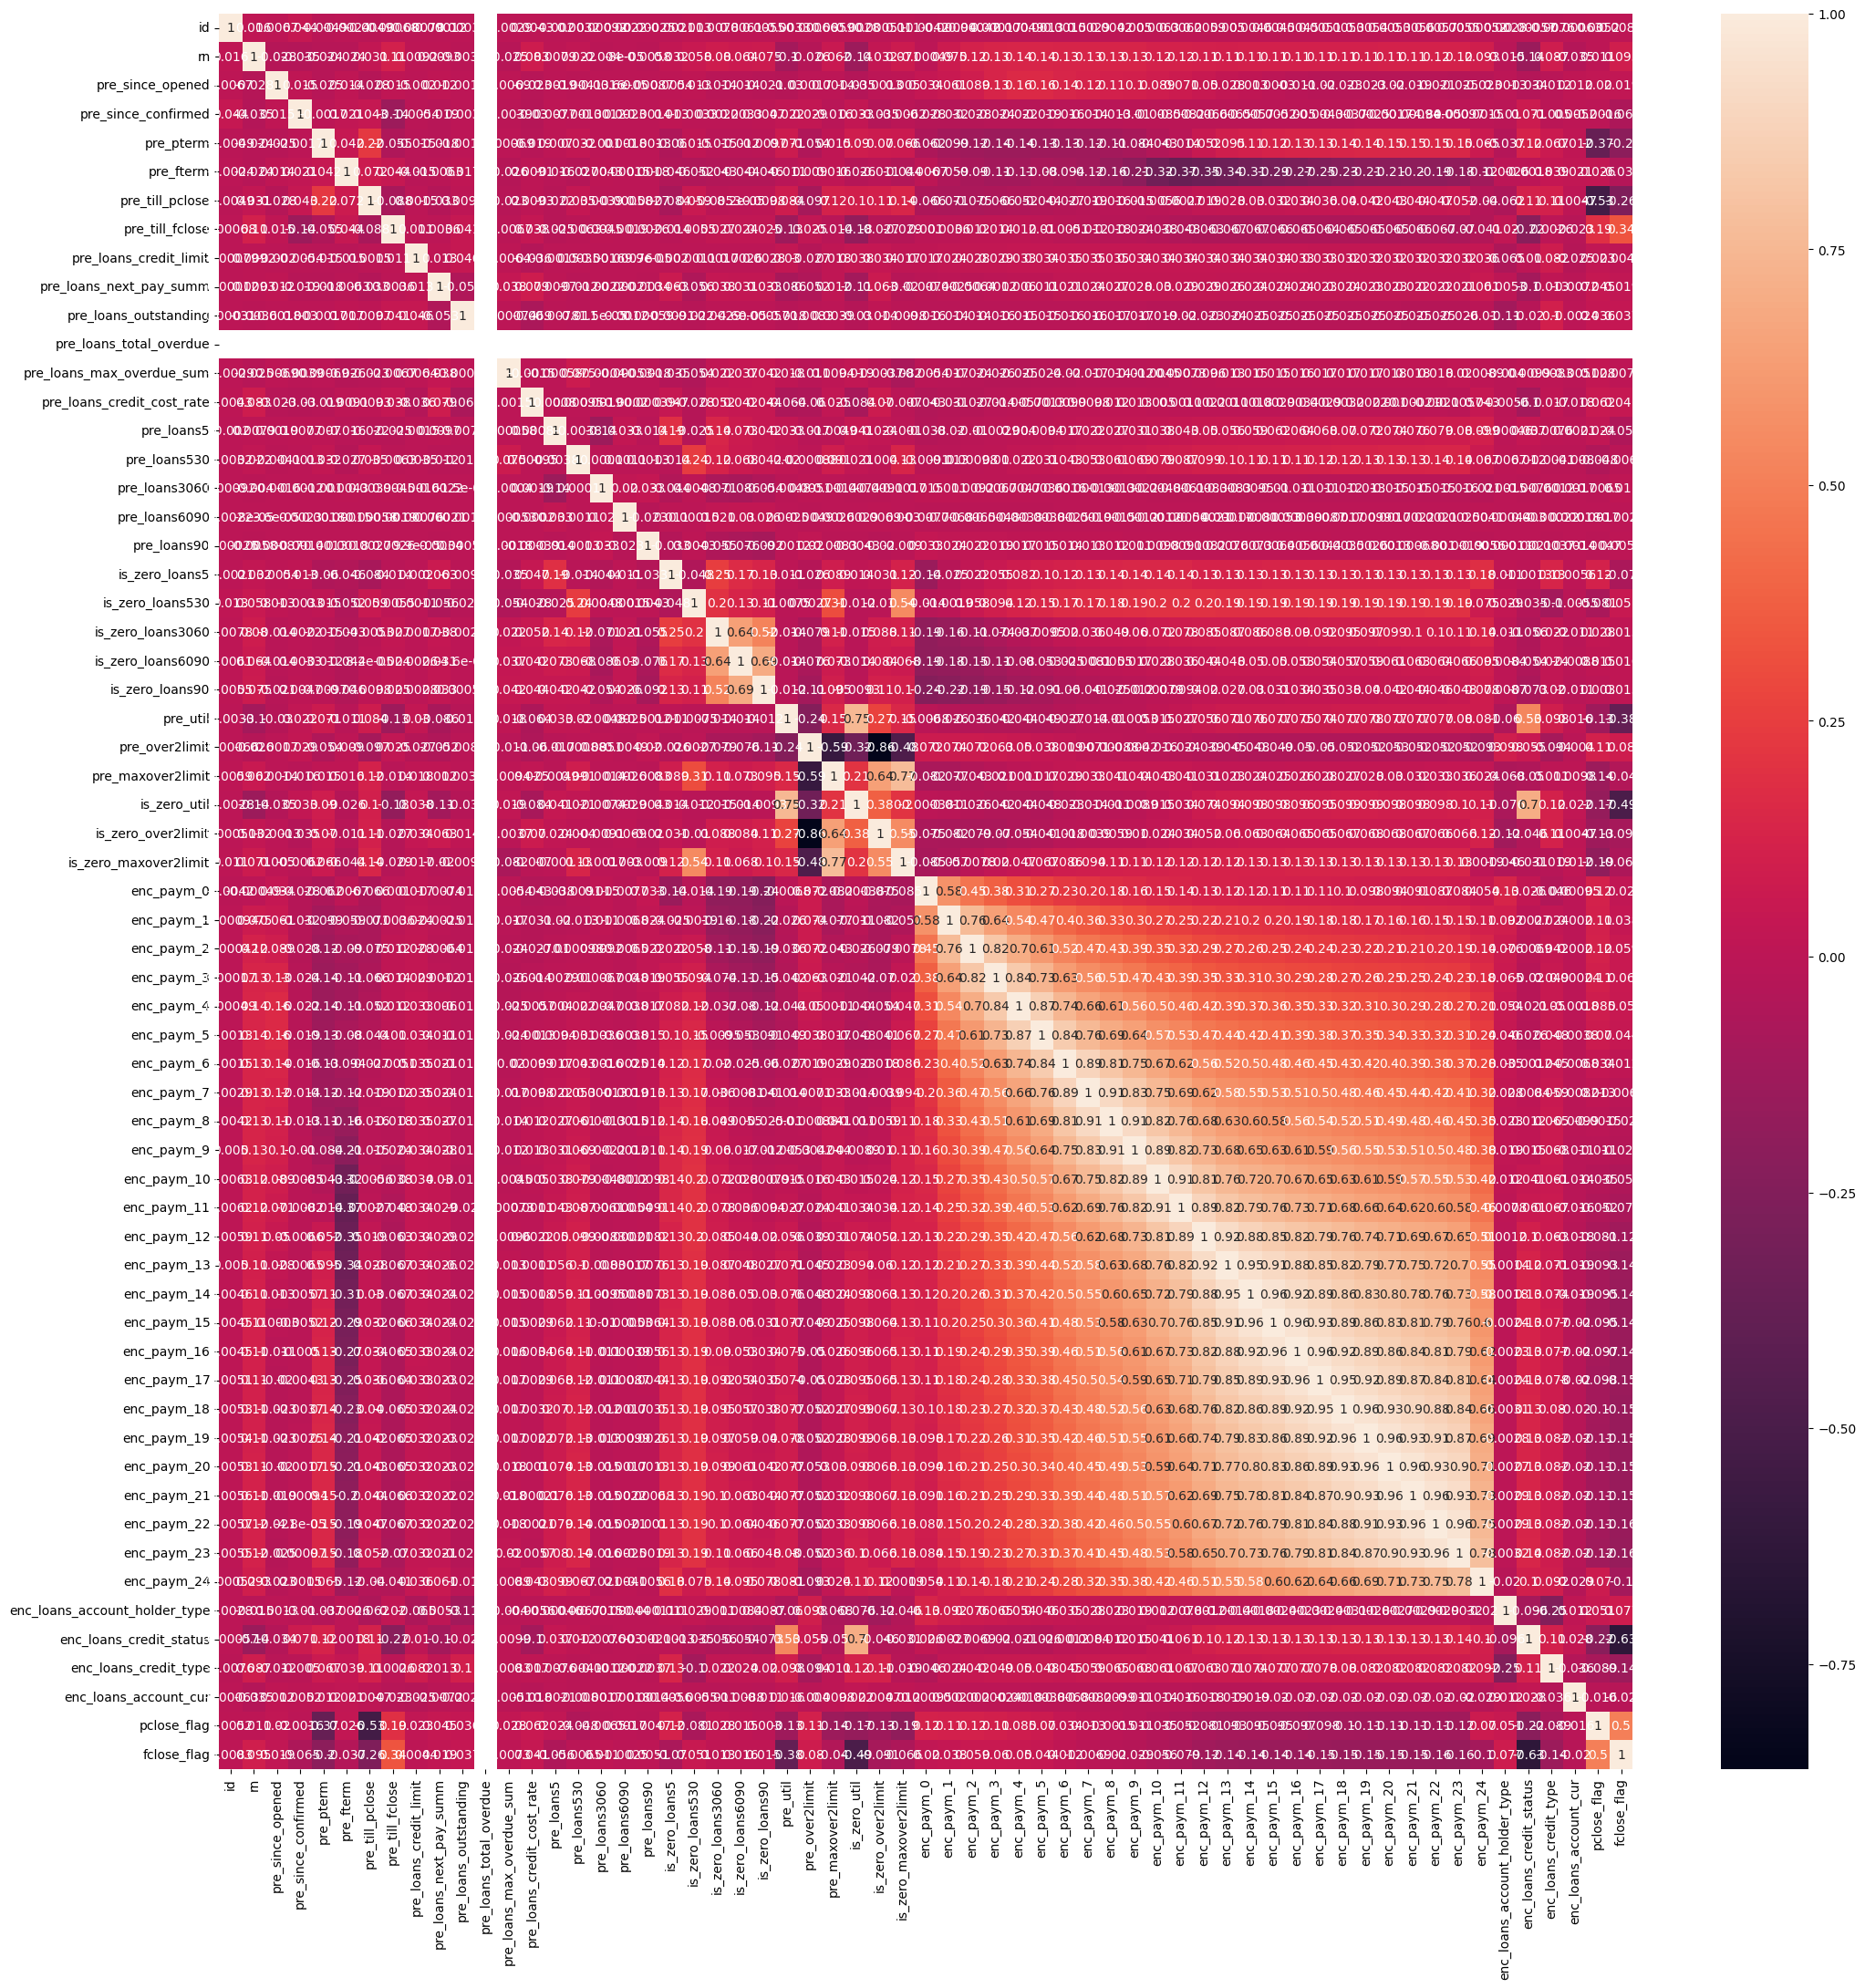

In [191]:
fig, ax = plt.subplots(figsize = (25, 25))
sns.heatmap(data.corr(), annot=True);

In [192]:
data.drop(columns=['rn'], inplace=True)

In [193]:
data.dtypes

id                               int64
pre_since_opened                 int64
pre_since_confirmed              int64
pre_pterm                        int64
pre_fterm                        int64
pre_till_pclose                  int64
pre_till_fclose                  int64
pre_loans_credit_limit           int64
pre_loans_next_pay_summ          int64
pre_loans_outstanding            int64
pre_loans_total_overdue          int64
pre_loans_max_overdue_sum        int64
pre_loans_credit_cost_rate       int64
pre_loans5                       int64
pre_loans530                     int64
pre_loans3060                    int64
pre_loans6090                    int64
pre_loans90                      int64
is_zero_loans5                   int64
is_zero_loans530                 int64
is_zero_loans3060                int64
is_zero_loans6090                int64
is_zero_loans90                  int64
pre_util                         int64
pre_over2limit                   int64
pre_maxover2limit        

In [194]:
data_2 = pd.read_csv(path+'/target.csv')

In [195]:
data_2.head(30)

id  flag
0    0     0
1    1     0
2    2     0
3    3     0
4    4     0
5    5     0
6    6     0
7    7     0
8    8     0
9    9     0
10  10     0
11  11     0
12  12     0
13  13     0
14  14     0
15  15     0
16  16     0
17  17     0
18  18     0
19  19     0
20  20     1
21  21     0
22  22     0
23  23     0
24  24     0
25  25     0
26  26     0
27  27     0
28  28     0
29  29     0

In [196]:
data_2 = data_2.iloc[:250000]
data_2.head()

id  flag
0   0     0
1   1     0
2   2     0
3   3     0
4   4     0

In [197]:
data_2.shape

(250000, 2)

In [198]:
merged_data = pd.merge(data, data_2 , on = 'id')
merged_data.shape

(1974724, 61)

In [199]:
merged_data.drop(columns=['id'], inplace=True)

In [200]:
merged_data.head()

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0                18                    9          2          3   
1                18                    9         14         14   
2                18                    9          4          8   
3                 4                    1          9         12   
4                 5                   12         15          2   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                1               11                      11   
3               16                7                      12   
4               11               12                      10   

   pre_loans_next_pay_summ  pre_loans_outstanding  pre_loans_total_overdue  \
0                        3                      3                        0   
1                        3                      3                        0   
2                        0                      5                        0   
3                        2                      3                        0   
4                        2                      3                        0   

   ...  enc_paym_22  enc_paym_23  enc_paym_24  enc_loans_account_holder_type  \
0  ...            3            3            4                              1   
1  ...            0            0            4                              1   
2  ...            0            0            4                              1   
3  ...            3            3            4                              1   
4  ...            3            3            4                              1   

   enc_loans_credit_status  enc_loans_credit_type  enc_loans_account_cur  \
0                        3                      4                      1   
1                        3                      4                      1   
2                        2                      3                      1   
3                        3                      1                      1   
4                        3                      4                      1   

   pclose_flag  fclose_flag  flag  
0            0            0     0  
1            0            0     0  
2            1            1     0  
3            0            0     0  
4            0            0     0  

[5 rows x 60 columns]

In [201]:
merged_data.isna().sum()

pre_since_opened                 0
pre_since_confirmed              0
pre_pterm                        0
pre_fterm                        0
pre_till_pclose                  0
pre_till_fclose                  0
pre_loans_credit_limit           0
pre_loans_next_pay_summ          0
pre_loans_outstanding            0
pre_loans_total_overdue          0
pre_loans_max_overdue_sum        0
pre_loans_credit_cost_rate       0
pre_loans5                       0
pre_loans530                     0
pre_loans3060                    0
pre_loans6090                    0
pre_loans90                      0
is_zero_loans5                   0
is_zero_loans530                 0
is_zero_loans3060                0
is_zero_loans6090                0
is_zero_loans90                  0
pre_util                         0
pre_over2limit                   0
pre_maxover2limit                0
is_zero_util                     0
is_zero_over2limit               0
is_zero_maxover2limit            0
enc_paym_0          

удаление дубликатов

In [202]:
data_unique = merged_data.drop_duplicates(keep='first')
data_unique.shape

(1477966, 60)

In [203]:
flag_counts = data_unique['flag'].value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = data_unique['flag'].value_counts('0')
print("Соотношение значений в столбце 'flag':")
print(flag_counts)

Количество значений в столбце 'flag':
flag
0    1424454
1      53512
Name: count, dtype: int64

Соотношение значений в столбце 'flag':
flag
0    0.963793
1    0.036207
Name: proportion, dtype: float64


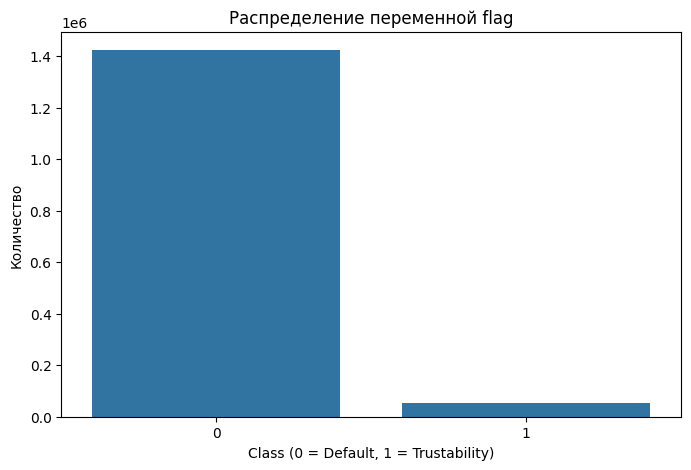

In [204]:
plt.figure(figsize=(8, 5))
sns.countplot(x="flag", data=data_unique)
plt.title("Распределение переменной flag")
plt.xlabel("Class (0 = Default, 1 = Trustability)")
plt.ylabel("Количество")
plt.show()

In [205]:
def corr_matrix(corr):
    plt.figure(figsize=(25,25))

    sns.heatmap(corr, annot=True)

    plt.title('Корреляция признаков')
    plt.show()

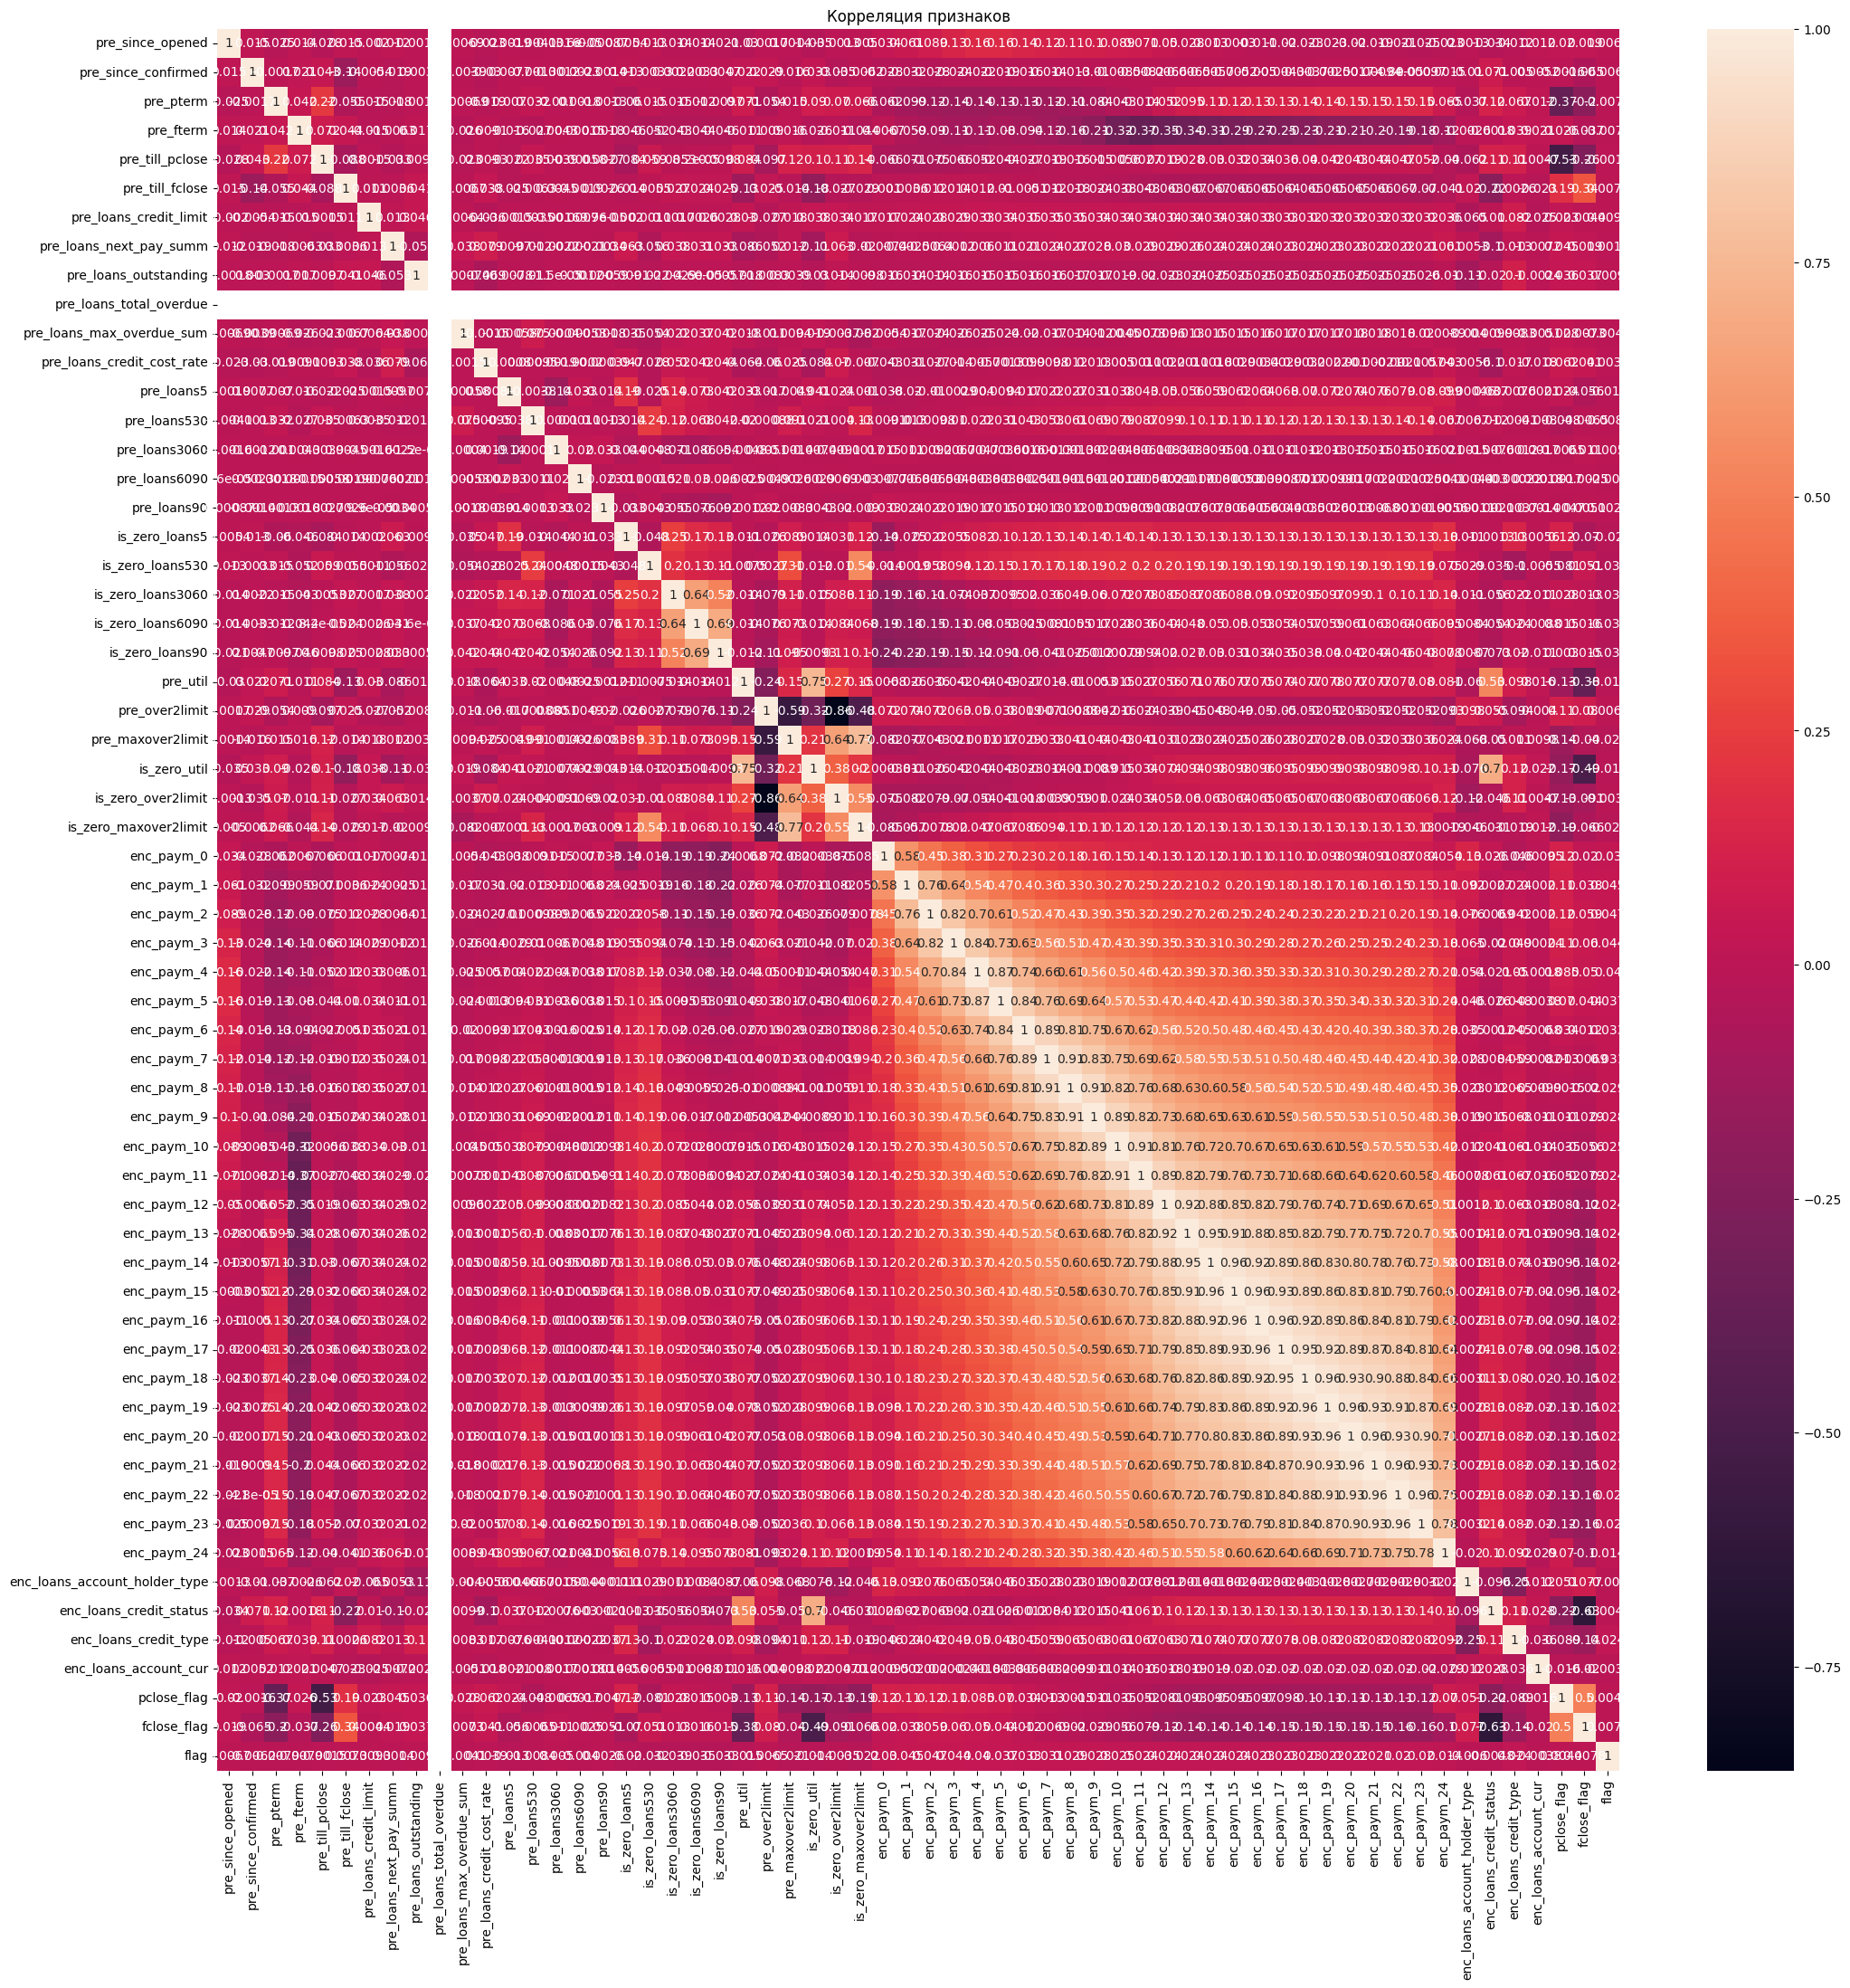

In [206]:
corr_matrix(merged_data.corr())

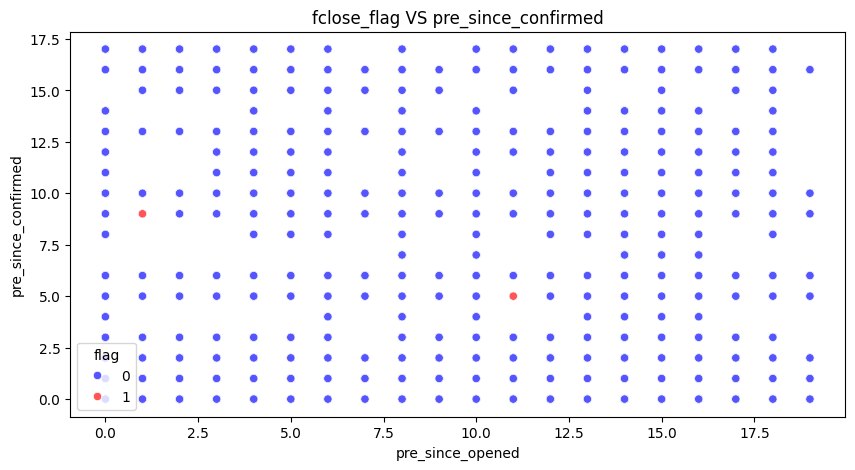

In [207]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=data_unique, #датасет
    x='pre_since_opened', #ось абсцисс
    y='pre_since_confirmed', #ось ординат
    hue='flag', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('fclose_flag VS pre_since_confirmed');

In [208]:
pd.set_option('display.max_columns', None)
data_unique.head()

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0                18                    9          2          3   
1                18                    9         14         14   
2                18                    9          4          8   
3                 4                    1          9         12   
4                 5                   12         15          2   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                1               11                      11   
3               16                7                      12   
4               11               12                      10   

   pre_loans_next_pay_summ  pre_loans_outstanding  pre_loans_total_overdue  \
0                        3                      3                        0   
1                        3                      3                        0   
2                        0                      5                        0   
3                        2                      3                        0   
4                        2                      3                        0   

   pre_loans_max_overdue_sum  pre_loans_credit_cost_rate  pre_loans5  \
0                          2                          11           6   
1                          2                          11           6   
2                          2                           8           6   
3                          2                           4           6   
4                          2                           4           6   

   pre_loans530  pre_loans3060  pre_loans6090  pre_loans90  is_zero_loans5  \
0            16              5              4            8               1   
1            16              5              4            8               1   
2            16              5              4            8               1   
3            16              5              4            8               0   
4            16              5              4            8               1   

   is_zero_loans530  is_zero_loans3060  is_zero_loans6090  is_zero_loans90  \
0                 1                  1                  1                1   
1                 1                  1                  1                1   
2                 1                  1                  1                1   
3                 1                  1                  1                1   
4                 1                  1                  1                1   

   pre_util  pre_over2limit  pre_maxover2limit  is_zero_util  \
0        16               2                 17             1   
1        16               2                 17             1   
2        15               2                 17             0   
3        16               2                 17             1   
4        16               2                 17             1   

   is_zero_over2limit  is_zero_maxover2limit  enc_paym_0  enc_paym_1  \
0                   1                      1           0           0   
1                   1                      1           0           0   
2                   1                      1           0           0   
3                   1                      1           1           0   
4                   1                      1           0           0   

   enc_paym_2  enc_paym_3  enc_paym_4  enc_paym_5  enc_paym_6  enc_paym_7  \
0           3           3           3           3           3           3   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           3   

   enc_paym_8  enc_paym_9  enc_paym_10  enc_paym_11  enc_paym_12  enc_paym_13  \
0           3           3

In [209]:
pd.reset_option('display.max_columns')

Применение One-Hot-Encoder (Pandas)

In [ ]:
data_unique = pd.get_dummies(data_unique, dtype=int, columns=['enc_loans_account_holder_type'], prefix='enc_loans_account_holder_type', drop_first=True)
data_unique = pd.get_dummies(data_unique, dtype=int, columns=['enc_loans_credit_status'], prefix='enc_loans_credit_status', drop_first=True)
data_unique = pd.get_dummies(data_unique, dtype=int, columns=['enc_loans_account_cur'], prefix='enc_loans_account_cur', drop_first=True)
data_unique = pd.get_dummies(data_unique, dtype=int, columns=['enc_loans_credit_type'], prefix='enc_loans_credit_type', drop_first=True)
#for i in range(25):
#    if f'enc_paym_{i}' in data_unique.columns:
#        data_unique = pd.get_dummies(data_unique, dtype=int, columns=[f'enc_paym_{i}'], prefix=f'enc_paym_{i}', drop_first=True)

In [211]:
data_unique.head()

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0                18                    9          2          3   
1                18                    9         14         14   
2                18                    9          4          8   
3                 4                    1          9         12   
4                 5                   12         15          2   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                1               11                      11   
3               16                7                      12   
4               11               12                      10   

   pre_loans_next_pay_summ  pre_loans_outstanding  pre_loans_total_overdue  \
0                        3                      3                        0   
1                        3                      3                        0   
2                        0                      5                        0   
3                        2                      3                        0   
4                        2                      3                        0   

   ...  enc_loans_credit_status_2  enc_loans_credit_status_3  \
0  ...                          0                          1   
1  ...                          0                          1   
2  ...                          1                          0   
3  ...                          0                          1   
4  ...                          0                          1   

   enc_loans_credit_status_4  enc_loans_credit_status_5  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   enc_loans_credit_status_6  enc_loans_credit_type_1  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        1   
4                          0                        0   

   enc_loans_credit_type_2  enc_loans_credit_type_3  enc_loans_credit_type_4  \
0                        0                        0                        1   
1                        0                        0                        1   
2                        0                        1                        0   
3                        0                        0                        0   
4                        0                        0                        1   

   enc_loans_credit_type_5  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 74 columns]

In [212]:
X = data_unique.drop(columns=['flag'])
y = data_unique['flag']

In [213]:
X.shape, y.shape

((1477966, 73), (1477966,))

In [214]:
#уменьшение выборки для демонстрации работы TPOT и H2O
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [215]:
'''
#from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Создание экземпляра SMOTE
und_sampler = RandomUnderSampler(random_state=42)

# Применение SMOTE к данным
X_train, y_train = und_sampler.fit_resample(X_train, y_train)
'''

'\n#from imblearn.over_sampling import SMOTE\nfrom imblearn.under_sampling import RandomUnderSampler\n# Создание экземпляра SMOTE\nund_sampler = RandomUnderSampler(random_state=42)\n\n# Применение SMOTE к данным\nX_train, y_train = und_sampler.fit_resample(X_train, y_train)\n'

In [216]:
print(X_train.shape, y_train.shape)

(1256271, 73) (1256271,)


In [217]:
flag_counts = y_train.value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = y_train.value_counts('0')
print("Cоотношение значений в столбце 'flag':")
print(flag_counts)
print()

Количество значений в столбце 'flag':
flag
0    1210743
1      45528
Name: count, dtype: int64

Cоотношение значений в столбце 'flag':
flag
0    0.963759
1    0.036241
Name: proportion, dtype: float64



In [218]:
flag_counts = y_test.value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = y_test.value_counts('0')
print("Cоотношение значений в столбце 'flag':")
print(flag_counts)
print()

Количество значений в столбце 'flag':
flag
0    213711
1      7984
Name: count, dtype: int64

Cоотношение значений в столбце 'flag':
flag
0    0.963987
1    0.036013
Name: proportion, dtype: float64



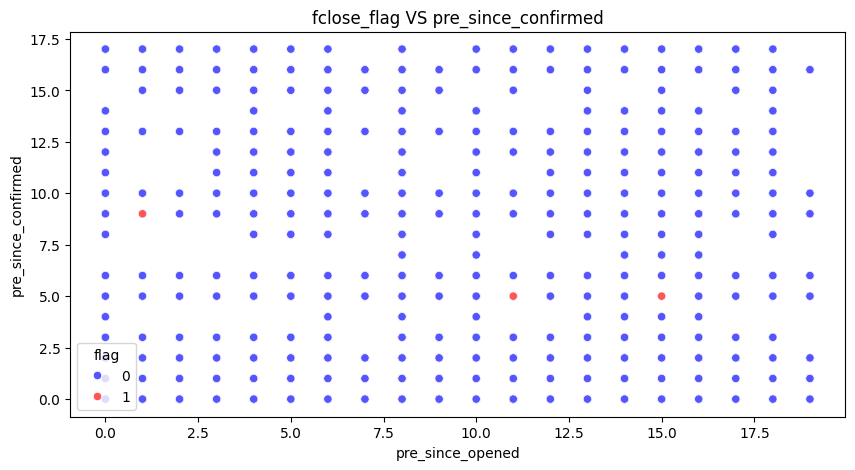

In [219]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=X_train, #датасет
    x='pre_since_opened', #ось абсцисс
    y='pre_since_confirmed', #ось ординат
    hue=y, #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('fclose_flag VS pre_since_confirmed');

# Логистическая регрессия

In [221]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [222]:
kf = KFold(n_splits=5)
log_reg_model = LogisticRegression(class_weight='balanced')

for train_index, test_index in kf.split(X_train):
    X_train_s, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_s, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    log_reg_model.fit(X_train_s, y_train_s)

In [223]:
y_log_pred = log_reg_model.predict(X_test)
y_log_proba = log_reg_model.predict_proba(X_test)[:, 1]

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC_AUC: {roc_auc_score(y_test, y_proba):.4f}")
print()
# Матрица ошибок
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Полный отчет
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6343
Balanced Accuracy: 0.5850
Precision: 0.0521
Recall: 0.5318
F1-Score: 0.0948
ROC_AUC: 0.6232

Confusion Matrix:
 [[136384  77327]
 [  3738   4246]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.64      0.77    213711
           1       0.05      0.53      0.09      7984

    accuracy                           0.63    221695
   macro avg       0.51      0.58      0.43    221695
weighted avg       0.94      0.63      0.75    221695



## Обучение TPOT

### Функции метрик

In [225]:
def tpot_prediction(test_data, model):
    y_pred = model.predict(test_data)
    y_proba = model.predict_proba(test_data)[:, 1]
    return y_pred, y_proba

### Процесс обучения

In [226]:
#%pip install tpot

In [227]:
import tpot
from tpot import TPOTClassifier

In [228]:
tpot_generations = [5, 10]
tpot_popsize = [50, 100]
tpot_models = []

In [229]:
# проводим обучение нескольких моделей tpot
for gen_param in tpot_generations:
    for pop_param in tpot_popsize:
        tpot = TPOTClassifier(
            generations=gen_param,
            population_size=pop_param,
            random_state=42,
            cv=5,
            max_eval_time_mins=10,
            scorers='f1',
        )

        tpot.fit(X_train, y_train)
        tpot_models.append(tpot)

Generation:  10%|█         | 1/10 [1:07:34<10:08:12, 4054.74s/it]


In [230]:
import datetime
date = datetime.datetime.now().strftime("%d%m%Y")
time = datetime.datetime.now().strftime("%H%M%S")

if not os.path.exists("tpot_results"):
    os.makedirs("tpot_results") 
tpot_export_file = open(f'tpot_results/tpot_result_{date}_{time}.txt', 'w')

In [ ]:
tpot_results_table = []
for tpot in tpot_models:
    specs = f'{tpot_models.index(tpot)+1} tpot model: generations={tpot.generations}, pop_size={tpot.population_size}'
    print(specs)
    print(specs, file=tpot_export_file)

    print('\nBest pipeline steps:', end='\n')
    for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
        step = f'{idx}. {transform}'
        print(step)
        print(step, file=tpot_export_file)
    
    test_predictions, test_probablity = tpot_prediction(X_test, tpot)
    print('Test metrics:')

    acc = f'{accuracy_score(y_test, test_predictions):.4f}'
    bal_acc = f'{balanced_accuracy_score(y_test, test_predictions):.4f}'
    prec = f'{precision_score(y_test, test_predictions)}'
    rec = f'{recall_score(y_test, test_predictions)}'
    f1 = f'{f1_score(y_test, test_predictions)}'
    roc_auc = f'{roc_auc_score(y_test, test_probablity)}'

    tpot_results_table.append({\
        'Generations': tpot.generations,
        'Population size': tpot.population_size,
        'Accuracy': acc,
        'Balanced Accuracy': bal_acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC_AUC': roc_auc
    })

    print(f"Accuracy: {acc}")
    print(f"Balanced Accuracy: {bal_acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    print(f"F1-Score: {f1}")
    print(f"ROC_AUC: {roc_auc}")

    print(f"Accuracy: {acc}", file=tpot_export_file)
    print(f"Balanced Accuracy: {bal_acc}", file=tpot_export_file)
    print(f"Precision: {prec}", file=tpot_export_file)
    print(f"Recall: {rec}", file=tpot_export_file)
    print(f"F1-Score: {f1}", file=tpot_export_file)
    print(f"ROC_AUC: {roc_auc}", file=tpot_export_file)

    # Матрица ошибок
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_predictions))
    # Полный отчет
    print("\nClassification Report:\n", classification_report(y_test, test_predictions))

    print("Confusion Matrix:\n", confusion_matrix(y_test, test_predictions), file=tpot_export_file)
    print("\nClassification Report:\n", classification_report(y_test, test_predictions), file=tpot_export_file)
    
    if not (tpot_models.index(tpot) == len(tpot_models)-1):
        print('\n'+('-='*20)+'-\n')
        print('\n'+('-='*20)+'-\n', file=tpot_export_file)

1 tpot model: generations=5, pop_size=50

Best pipeline steps:
1. MaxAbsScaler()
2. VarianceThreshold(threshold=0.0003878045217)
3. FeatureUnion(transformer_list=[('skiptransformer', SkipTransformer()),
                               ('passthrough', Passthrough())])
4. FeatureUnion(transformer_list=[('skiptransformer', SkipTransformer()),
                               ('passthrough', Passthrough())])
5. DecisionTreeClassifier(max_depth=13, min_samples_leaf=8, min_samples_split=18,
                       random_state=42)
Test metrics:
Accuracy: 0.9637
Balanced Accuracy: 0.5003
Precision: 0.0972
Recall: 0.0009
F1-Score: 0.0017
ROC_AUC: 0.6308

Confusion Matrix:
 [[213646     65]
 [  7977      7]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    213711
           1       0.10      0.00      0.00      7984

    accuracy                           0.96    221695
   macro avg       0.53      0.50      0.49    22169

In [232]:
tpot_export_file.close()

In [ ]:
tpot_results_df = pd.DataFrame(tpot_results_table)
tpot_results_df.head()

## Обучение H2O

In [233]:
import h2o
from h2o.automl import H2OAutoML

In [234]:
# Ячейка 2: Инициализация H2O и загрузка данных
h2o.init(nthreads=-1, max_mem_size="4G", ip="127.0.0.1", port='54321')

Checking whether there is an H2O instance running at http://127.0.0.1:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.451-b10, mixed mode)
  Starting server from C:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\AntMur00\AppData\Local\Temp\tmpnhfray5f
  JVM stdout: C:\Users\AntMur00\AppData\Local\Temp\tmpnhfray5f\h2o_AntMur00_started_from_python.out
  JVM stderr: C:\Users\AntMur00\AppData\Local\Temp\tmpnhfray5f\h2o_AntMur00_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Asia/Yekaterinburg
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    1 month and 19 days
H2O_cluster_name:           H2O_from_python_AntMur00_nya1vj
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.542 Gb
H2O_cluster_total_cores:    6
H2O_cluster_allowed_cores:  6
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.10 final
--------------------------  -------------------------------

In [235]:
print(f'X_train.shape :{X_train.shape}')
print(f'X_test.shape:{X_test.shape}')

X_train.shape :(1256271, 73)
X_test.shape:(221695, 73)


In [236]:
h2o_train_y = y_train.apply(lambda x: "yes" if x == 1 else "no")
h2o_y_test = y_test.apply(lambda x: "yes" if x == 1 else "no")

In [237]:
# Преобразование в H2O фреймы
train_h2o = h2o.H2OFrame(pd.concat([X_train, h2o_train_y], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([X_test, h2o_y_test], axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [238]:
# Определение целевой переменной и признаков
target = 'flag'
features = list(X_train.columns)

In [239]:
train_h2o

pre_since_opened    pre_since_confirmed    pre_pterm    pre_fterm    pre_till_pclose    pre_till_fclose    pre_loans_credit_limit    pre_loans_next_pay_summ    pre_loans_outstanding    pre_loans_total_overdue    pre_loans_max_overdue_sum    pre_loans_credit_cost_rate    pre_loans5    pre_loans530    pre_loans3060    pre_loans6090    pre_loans90    is_zero_loans5    is_zero_loans530    is_zero_loans3060    is_zero_loans6090    is_zero_loans90    pre_util    pre_over2limit    pre_maxover2limit    is_zero_util    is_zero_over2limit    is_zero_maxover2limit    enc_paym_0    enc_paym_1    enc_paym_2    enc_paym_3    enc_paym_4    enc_paym_5    enc_paym_6    enc_paym_7    enc_paym_8    enc_paym_9    enc_paym_10    enc_paym_11    enc_paym_12    enc_paym_13    enc_paym_14    enc_paym_15    enc_paym_16    enc_paym_17    enc_paym_18    enc_paym_19    enc_paym_20    enc_paym_21    enc_paym_22    enc_paym_23    enc_paym_24    enc_loans_account_cur    pclose_flag    fclose_flag    enc_loans_account_holder_type_1    enc_loans_account_holder_type_2    enc_loans_account_holder_type_3    enc_loans_account_holder_type_4    enc_loans_account_holder_type_5    enc_loans_account_holder_type_6    enc_loans_credit_status_1    enc_loans_credit_status_2    enc_loans_credit_status_3    enc_loans_credit_status_4    enc_loans_credit_status_5    enc_loans_credit_status_6    enc_loans_credit_type_1    enc_loans_credit_type_2    enc_loans_credit_type_3    enc_loans_credit_type_4    enc_loans_credit_type_5  flag
------------------  ---------------------  -----------  -----------  -----------------  -----------------  ------------------------  -------------------------  -----------------------  -------------------------  ---------------------------  ----------------------------  ------------  --------------  ---------------  ---------------  -------------  ----------------  ------------------  -------------------  -------------------  -----------------  ----------  ----------------  -------------------  --------------  --------------------  -----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -------------  -----------------------  -------------  -------------  ---------------------------------  ---------------------------------  ---------------------------------  ---------------------------------  ---------------------------------  ---------------------------------  ---------------------------  ---------------------------  ---------------------------  ---------------------------  ---------------------------  ---------------------------  -------------------------  -------------------------  -------------------------  -------------------------  -------------------------  ------
                 0                      9            4            8                  1                 11                        12                          1                        4                          0                            2                             3             6              16                5                4              8                 1                   1                    1                    1                  1           3                 2                   17               0                     1                        1             0             0             0             0             0             0             0             0             0             0              0              1              0              0              0              0              0              0              0              0              1              0              0              0              4                        1              1              1     

In [240]:
# Запуск H2O AutoML
aml = H2OAutoML(max_models=50, max_runtime_secs=3600, seed=42, verbosity='info', nfolds=5)
aml.train(x=features, y=target, training_frame=train_h2o)

AutoML progress: |
01:31:54.130: Project: AutoML_1_20250517_13154
01:31:54.130: Setting stopping tolerance adaptively based on the training frame: 0.001
01:31:54.130: Build control seed: 42
01:31:54.131: training frame: Frame key: AutoML_1_20250517_13154_training_Key_Frame__upload_93b990539daa528b26803cea276e460c.hex    cols: 74    rows: 1256271  chunks: 48    size: 58178612  checksum: 6272177873915889944
01:31:54.131: validation frame: NULL
01:31:54.131: leaderboard frame: NULL
01:31:54.131: blending frame: NULL
01:31:54.131: response column: flag
01:31:54.131: fold column: null
01:31:54.131: weights column: null
01:31:54.137: AutoML: XGBoost is not available; skipping it.
01:31:54.141: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g,

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_4_AutoML_1_20250517_13154


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          246716                 0            10           6.4           1             784           388.7

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.033006715647254894
RMSE: 0.18167750451625786
LogLoss: 0.14125063907379054
Mean Per-Class Error: 0.4055943044705575
AUC: 0.7246317176279452
AUCPR: 0.1646842679141618
Gini: 0.4492634352558904

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09141764819566958
       no           yes    Error    Rate
-----  -----------  -----  -------  -------------------
no     1.17886e+06  31880  0.0263   (31880.0/1210743.0)
yes    35733        9795   0.7849   (35733.0/45528.0)
Total  1.2146e+06   41675  0.0538   (67613.0/1256271.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value        idx
---------------------------  -----------  -----------  -----
max f1                       0.0914176    0.224648     190
max f2                       0.0499676    0.272614     256
max f0point5                 0.136404     0.261831     148
max accuracy                 0.323982     0.964188     59
max precision                0.856335     1            0
max recall                   0.0108553    1            398
max specificity              0.856335     1            0
max absolute_mcc             0.119105     0.200002     162
max min_per_class_accuracy   0.0355283    0.659418     301
max mean_per_class_accuracy  0.0386513    0.664154     290
max tns                      0.856335     1.21074e+06  0
max fns                      0.856335     45527        0
max fps                      0.00998206   1.21074e+06  399
max tps                      0.0108553    45528        398
max tnr                      0.856335     1            0
max fnr                      0.856335     0.999978     0
max fpr                      0.00998206   1            399
max tpr                      0.0108553    1            398

Gains/Lift Table: Avg response rate:  3,62 %, avg score:  3,64 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100002                   0.162704           10.6811   10.6811            0.387089         0.247744   0.387089                    0.247744            0.106813        0.106813                   968.109   968.109            0.100454
2        0.0200005                   0.115376           5.71064   8.19587            0.206957         0.135016   0.297023                    0.19138             0.0571077       0.163921                   471.064   719.587            0.149333
3        0.0300015                   0.0954148          4.04764   6.81305            0.146689         0.104319   0.246909                    0.162358            0.0404806       0.204402                   304.764   581.305            0.180958
4        0.0400001                   0.0832238          3.06007   5.87494            0.110899         0.0888864  0.212911                    0.143993            0.0305966       0.234998                   206.007   487.494            0.202331
5        0.0500004              

In [241]:
# Вывод Leaderboard
print("\nLeaderboard:")
print(aml.leaderboard)


Leaderboard:
model_id                                          auc    logloss      aucpr    mean_per_class_error      rmse        mse
GBM_4_AutoML_1_20250517_13154                0.670077   0.148507  0.0854339                0.426811  0.185055  0.0342452
GBM_3_AutoML_1_20250517_13154                0.669547   0.148467  0.0865202                0.426223  0.184956  0.0342088
GBM_grid_1_AutoML_1_20250517_13154_model_5   0.66945    0.148534  0.0858652                0.423939  0.185022  0.0342332
GBM_1_AutoML_1_20250517_13154                0.669299   0.148284  0.0873413                0.424832  0.184912  0.0341923
GBM_2_AutoML_1_20250517_13154                0.668396   0.148553  0.0866744                0.4288    0.184954  0.0342078
GBM_grid_1_AutoML_1_20250517_13154_model_13  0.667412   0.148663  0.08577                  0.426263  0.184998  0.0342244
GBM_5_AutoML_1_20250517_13154                0.66587    0.148883  0.0837108                0.431215  0.185119  0.0342689
GBM_grid_1_AutoML_

In [242]:
# Получение лучшей модели
model_ids = aml.leaderboard.as_data_frame()['model_id'].tolist()
# 2. Выбираем топ-3 модели
top_n = 3
model_ids = model_ids[:top_n]

h2o_models = [h2o.get_model(mid) for mid in model_ids]

In [243]:
import datetime
date = datetime.datetime.now().strftime("%d%m%Y")
time = datetime.datetime.now().strftime("%H%M")

if not os.path.exists("h2o_models"):
    os.makedirs("h2o_models") 
h2o_export_file = open(f'h2o_models/h2o_result_{date}_{time}.txt', 'w')

In [ ]:
# Готовим таблицу для результатов
h2o_results_table = []

# Предсказываем и оцениваем каждую модель
for model in h2o_models:
    preds = model.predict(test_h2o)
    pred_labels = preds.as_data_frame()['yes']
    pred_labels = pred_labels.apply(lambda x: 1 if x > 0.5 else 0)
    pred_probs = preds.as_data_frame()['yes']  # вероятность класса 1
    
    model_name = f'Model {h2o_models.index(model)+1}: {model.algo}:{model.model_id}'
    print(model_name)
    print(model_name, file=h2o_export_file)

    model_params_info = f'\nModel parameters:\n{model.params}'
    print(model_params_info)
    print(model_params_info,file=h2o_export_file)
    
    print(f'\nPredications:\n{preds}')

    # Истинные значения
    y_true = y_test.values
    y_true = pd.get_dummies(y_true, dtype=int, columns=['flag'], drop_first=True)


    # Метрики
    acc = accuracy_score(y_true, pred_labels)
    bal_acc = f'{balanced_accuracy_score(y_true, pred_labels)}'
    prec = precision_score(y_true, pred_labels)
    rec = recall_score(y_true, pred_labels)
    f1 = f1_score(y_true, pred_labels)
    roc_auc = roc_auc_score(y_true, pred_probs)

    h2o_results_table.append({
        'Model Name': model.model_id,
        'Algorithm': model.algo,
        'Accuracy': acc,
        'Balanced Accuracy': bal_acc
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC_AUC': roc_auc
    })

    print(f'Confusion Matrix:\n{confusion_matrix(y_true, pred_labels)}')
    print(f'\nClassification Report:\n{classification_report(y_true, pred_labels)}')
    
    print(f'Confusion Matrix:\n{confusion_matrix(y_true, pred_labels)}', file=h2o_export_file)
    print(f'\nClassification Report:\n{classification_report(y_true, pred_labels)}', file=h2o_export_file)

    if model.algo in ('stackedensemble'):
        print(f'Base models:\n{model.base_models}')
        print(f'\nMetalearner:\n{model.metalearner().algo}')
        
        print(f'Base models:\n{model.base_models}', file=h2o_export_file)
        print(f'\nMetalearner:\n{model.metalearner().algo}', file=h2o_export_file)

    if not (h2o_models.index(model) == len(h2o_models)-1):
        print('\n'+('-='*20)+'-\n')
        print('\n'+('-='*20)+'-\n', file=h2o_export_file)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Model 1: gbm:GBM_4_AutoML_1_20250517_13154

Model parameters:
{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_4_AutoML_1_20250517_13154', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_4_AutoML_1_20250517_13154'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250517_13154_training_Key_Frame__upload_93b990539daa528b26803cea276e460c.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20250517_13154_training_Key_Frame__upload_93b990539daa528b26803cea276e460c.hex'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250517_13154_training_Key_Frame__upload_93b990539daa528b26803cea276e460c.hex', 'type': 'Key

In [245]:
h2o_export_file.close()

In [ ]:
h2o_results_df = pd.DataFrame(h2o_results_table)
h2o_results_df.head()

Model Name Algorithm  Accuracy  Precision  \
0               GBM_4_AutoML_1_20250517_13154       gbm  0.963959   0.200000   
1               GBM_3_AutoML_1_20250517_13154       gbm  0.963987   0.500000   
2  GBM_grid_1_AutoML_1_20250517_13154_model_5       gbm  0.963973   0.285714   

     Recall  F1-score   ROC AUC  
0  0.000251  0.000500  0.671726  
1  0.000125  0.000250  0.670320  
2  0.000251  0.000501  0.669856

In [247]:
'''
for model in models:
    model_path = h2o.save_model(model=model, path="h2o_models", force=True)
    print(f"Model saved to: {model_path}")
'''

'\nfor model in models:\n    model_path = h2o.save_model(model=model, path="h2o_models", force=True)\n    print(f"Model saved to: {model_path}")\n'

In [249]:
h2o.shutdown()

H2O session _sid_859e closed.
